In [2]:
import dask
import dask.dataframe as dd
import pandas as pd
from pathlib import Path
import numpy as np

from finx_option_data.transforms import (
    transform_last_trading_day_human, 
    transform_add_last_trading_day_week_number,
    transform_columns_datetime, 
    transform_symbol_underlying, 
    transform_add_strike,
    transform_add_call_put,
    find_matching_row,
)

This is a data processing pipline. 

Steps, 
- Extract the data from S3 (atm, read from local fine drive)
- Do transforms
- Filter for just SPY data
- Aggregate over the last hour of the market (3-4pm US/Eastern).
- Construct the -Friday+Monday comp(pd.DataFrame) object
- Calculate diffs (volatility, mid price, delta)
- Generate summary plot

Todos
- [ ] for lastTradingDayWeekNumber_f, save metrics for (vol_diff, mid_diff, delta_diff, vega_diff, gamma_diff wrt (DTE, vols=30,40,50,60,70))

In [3]:
# dask the entire directory
# df = dd.read_parquet("/Users/vifo/work/lsc/finx-option-data/data/raw/2022/4/25/*.parquet.gzip")

# pandas read the entire directory
data_dir = Path('/Users/vifo/work/lsc/finx-option-data/data/raw/2022/4/25')
df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet.gzip')
)

# single_file = "/Users/vifo/work/lsc/finx-option-data/data/raw/2022/4/25/1650878196.parquet.gzip"
# df = dd.read_parquet(single_file)
# df = pd.read_parquet(single_file)

In [ ]:
# pd.to_datetime(df['expirationDate'], unit="ms")
# dd.to_datetime(df['expirationDate'], unit="ms").compute()
# df.symbol.str.split("_", expand=True, n=1).compute()[0]

In [4]:
def transform(df):
    df = transform_columns_datetime(df)
    print("transform_columns_datetime")
    
    df = transform_symbol_underlying(df)
    print("transform_symbol_underlying")
    
    df = transform_add_strike(df)
    print("transform_add_strike")
    
    df = transform_add_call_put(df)
    print("transform_add_call_put")

    df = transform_last_trading_day_human(df)
    print("transform_last_trading_day_human")

    df = transform_add_last_trading_day_week_number(df)
    print("transform_last_trading_day_human")
    
    return df

tdf = transform(df) #.compute()

transform_columns_datetime
transform_symbol_underlying
transform_add_strike
transform_add_call_put
transform_last_trading_day_human
transform_last_trading_day_human


In [5]:
def filter_df(df, 
           underlyings: list=None, 
           last_trading_day_min=None, 
           last_trading_day_max=None
    ):
    
    if underlyings is not None:
        df = df[ df['underlying'].isin(underlyings)].copy()
    
    if last_trading_day_min is not None:
        df = df[last_trading_day_min <= df["lastTradingDay"]].copy()
    
    if last_trading_day_max is not None:
        df = df[df["lastTradingDay"] <= last_trading_day_max].copy()
        
    return df

tdf = filter_df(df, underlyings=["SPY"])

In [6]:
x = pd.to_datetime('2022-04-25 20:00')

tdf = (tdf.
     query("@x <= sampleTimeInLong").
     groupby("symbol").
     agg({

        "ask": "last",
        "bid": "last", 
        "strike": "last", 
        "call_put": "last", 
        "delta": "last",
        "lastTradingDay": "last", 
        "quoteTimeInLong": "last",
        "daysToExpiration": "last",
        "volatility": "last",
        "lastTradingDayDes": "last",
        "lastTradingDayWeekNumber": "last",

    }).sort_values(["symbol"])
).copy()

In [7]:
idf = tdf.copy()

def gen_friday_and_following_monday(input_df):
    """generate a df with Friday data as Front following Monday (t+1 market days) as Back"""
    df = input_df.copy()
    for _, grouped in df.groupby(["strike", "call_put"]):
        for idx, row in grouped.iterrows():
            last_ew_row = find_matching_row(df, row, dte_diff=-3)
            df.loc[idx, "matchingSymbol"] = np.NaN if last_ew_row is None else last_ew_row.name
    comp = pd.merge(df, df, left_on="matchingSymbol", right_index=True, suffixes=("_f", "_b"))
    return comp


def gen_friday_and_following_friday(input_df):
    """generate a df with Friday data as Front following Friday (t+7 market days) as Back"""
    df = input_df.copy()
    for _, grouped in df.groupby(["strike", "call_put"]):
        for idx, row in grouped.iterrows():
            last_ew_row = find_matching_row(df, row, dte_diff=-7)
            df.loc[idx, "matchingSymbol"] = np.NaN if last_ew_row is None else last_ew_row.name
    comp = pd.merge(df, df, left_on="matchingSymbol", right_index=True, suffixes=("_f", "_b"))
    return comp

comp = gen_friday_and_following_monday(idf)

DTE = [11]


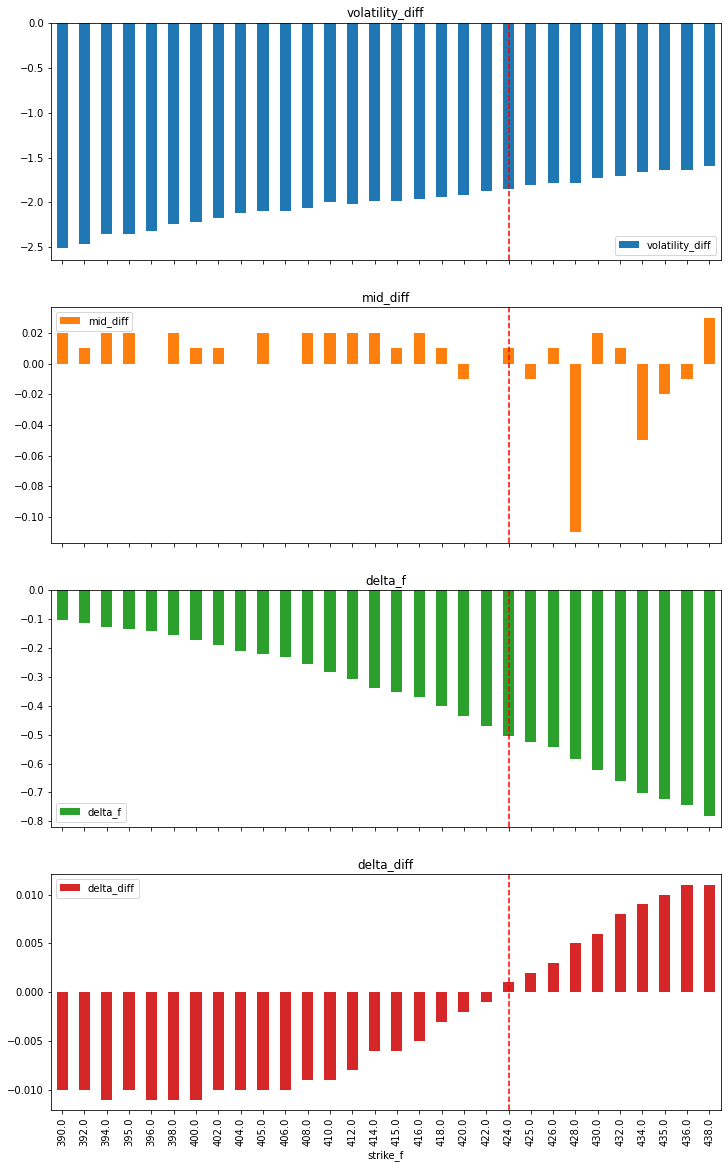

In [8]:
def calc_front_back_mid_diff(df) -> None:
    """
    Calc the mid diff between -AskBid_front + AskBid_back.
    Stores in mid_[f|b|diff].
    Returns: None
    """
    df["mid_f"] = (df["ask_f"]-df["bid_f"])
    df["mid_b"] = (df["ask_b"]-df["bid_b"])
    df["mid_diff"] = - df["mid_f"] + df["mid_b"]
    return None

def calc_front_back_volitality_diff(df) -> None:
    """
    Calc the volatility diff between -volatility_f + volatility_b
    Stores in volatility_diff.
    Returns: None
    """
    df["volatility_diff"] = -df["volatility_f"] + df["volatility_b"]
    return None

def calc_front_back_delta_diff(df) -> None:
    """
    Calc the delta diff between -delta_f + delta_b
    Stores in delta_diff
    Returns: None
    """
    df["delta_diff"] = - df["delta_f"] + df["delta_b"]
    return None

calc_front_back_mid_diff(comp)
calc_front_back_volitality_diff(comp)
calc_front_back_delta_diff(comp)

plot_df = comp.query("lastTradingDayDes_f == 'EW1'")

print(f"DTE = {plot_df.daysToExpiration_f.unique()}")

call_put = "p"

# plot df
plot_df = (
    plot_df[["volatility_diff", "mid_diff", "delta_f", "delta_diff", "call_put_f", "strike_f"]].
    query(f"call_put_f == '{call_put}'").
    query("-0.8 < delta_f and delta_f < -0.1").
    set_index("strike_f")
)

# gets subplots
axes = plot_df.plot.bar(subplots=True, figsize=(12, 20))

# determine x value and plot_df index for ATM (50 delta) strike
delta_50_index_value = plot_df.delta_f.add(0.5).abs().idxmin()
x_value = plot_df.index.searchsorted(delta_50_index_value)

# highlight the ATM strike
for ax in axes:
    ax.axvline(x_value, color='red', linestyle='dashed')

In [9]:
xdf = (comp.query(f"call_put_f == '{call_put}'").
    query("-0.8 < delta_f and delta_f < -0.1").
    set_index("strike_f"))

xdf[xdf.index == delta_50_index_value][["lastTradingDayWeekNumber_f", "mid_diff", "volatility_diff", "delta_diff", "delta_f", "daysToExpiration_f"]]

,lastTradingDayWeekNumber_f,mid_diff,volatility_diff,delta_diff,delta_f,daysToExpiration_f
strike_f,,,,,,
424.0,2022-17,0.00,-4.008,0.003,-0.518,4
424.0,2022-18,0.01,-1.854,0.001,-0.506,11
424.0,2022-19,0.01,-1.187,0.001,-0.501,18
424.0,2022-20,0.19,-0.780,0.001,-0.497,25
424.0,2022-22,0.04,0.266,0.002,-0.493,36
